In [1]:
import logging
import warnings
import multiprocessing

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

from time import time
from pathlib import Path
from collections import defaultdict

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

CORES = multiprocessing.cpu_count()
DATA_PATH = './data'

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
corpus_file = '{}/models/corpus.csv.xz'.format(DATA_PATH)
df = pd.read_csv(corpus_file, header=None, compression='xz')
df.head(10)

,0
0,3d reconstruct method digit preserv cultur her...
1,3d viewer softwar build base scan synthet fema...
2,global strategi high tech multin corpor case s...
3,inform system instrument qualiti program healt...
4,experi cardiolog unit develop qualiti program ...
5,inform system instrument qualiti program
6,cluster categor appli cryptanalysi
7,criptoanalisi outwit use context sensit grammar
8,cryptograph algorithm identif use machin learn...
9,influenc baroclin sistem sever rainstorm buena...


In [3]:
sent = [row.split() for row in df[0]]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 14:20:29: collecting all words and their counts
INFO - 14:20:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:20:29: PROGRESS: at sentence #10000, processed 81138 words and 56401 word types
INFO - 14:20:29: PROGRESS: at sentence #20000, processed 160679 words and 100301 word types
INFO - 14:20:29: PROGRESS: at sentence #30000, processed 241467 words and 140478 word types
INFO - 14:20:30: PROGRESS: at sentence #40000, processed 321825 words and 177942 word types
INFO - 14:20:30: PROGRESS: at sentence #50000, processed 405075 words and 215439 word types
INFO - 14:20:30: PROGRESS: at sentence #60000, processed 485540 words and 249162 word types
INFO - 14:20:30: PROGRESS: at sentence #70000, processed 567153 words and 283833 word types
INFO - 14:20:31: PROGRESS: at sentence #80000, processed 649364 words and 316239 word types
INFO - 14:20:31: PROGRESS: at sentence #90000, processed 732386 words and 347308 word types
INFO - 14:20:31: PROGRESS: at sentence #1

In [4]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

print(len(word_freq))
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

42855
['use', 'base', 'system', 'model', 'analysi', 'network', 'approach', 'applic', 'method', 'data']


In [5]:
model = Word2Vec(min_count=20, window=2, size=300, sample=6e-5,
                 alpha=0.03, min_alpha=0.0007, negative=20, workers=CORES-1)

In [6]:
t = time()
model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:20:42: collecting all words and their counts
INFO - 14:20:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:20:43: PROGRESS: at sentence #10000, processed 76066 words, keeping 9472 word types
INFO - 14:20:43: PROGRESS: at sentence #20000, processed 150665 words, keeping 13947 word types
INFO - 14:20:44: PROGRESS: at sentence #30000, processed 226491 words, keeping 17547 word types
INFO - 14:20:44: PROGRESS: at sentence #40000, processed 301790 words, keeping 20990 word types
INFO - 14:20:44: PROGRESS: at sentence #50000, processed 379942 words, keeping 24313 word types
INFO - 14:20:45: PROGRESS: at sentence #60000, processed 455161 words, keeping 27036 word types
INFO - 14:20:45: PROGRESS: at sentence #70000, processed 532141 words, keeping 29874 word types
INFO - 14:20:45: PROGRESS: at sentence #80000, processed 609425 words, keeping 32310 word types
INFO - 14:20:46: PROGRESS: at sentence #90000, processed 687208 words, keeping 34885 word types


In [7]:
t = time()
model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

e 0, out_qsize 0
INFO - 14:21:55: EPOCH 10 - PROGRESS: at 93.35% examples, 54169 words/s, in_qsize 0, out_qsize 0
INFO - 14:21:56: worker thread finished; awaiting finish of 2 more threads
INFO - 14:21:56: worker thread finished; awaiting finish of 1 more threads
INFO - 14:21:56: worker thread finished; awaiting finish of 0 more threads
INFO - 14:21:56: EPOCH - 10 : training on 942450 raw words (419943 effective words) took 7.7s, 54446 effective words/s
INFO - 14:21:57: EPOCH 11 - PROGRESS: at 10.83% examples, 43481 words/s, in_qsize 0, out_qsize 0
INFO - 14:21:58: EPOCH 11 - PROGRESS: at 23.64% examples, 47056 words/s, in_qsize 1, out_qsize 0
INFO - 14:21:59: EPOCH 11 - PROGRESS: at 36.45% examples, 48013 words/s, in_qsize 0, out_qsize 0
INFO - 14:22:00: EPOCH 11 - PROGRESS: at 51.29% examples, 51432 words/s, in_qsize 0, out_qsize 0
INFO - 14:22:01: EPOCH 11 - PROGRESS: at 65.02% examples, 52595 words/s, in_qsize 0, out_qsize 0
INFO - 14:22:02: EPOCH 11 - PROGRESS: at 79.77% examples,

### T-SNE Plot

In [8]:
def tsnescatterplot(model, word, list_names):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality
    reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

INFO - 14:24:22: precomputing L2-norms of word weight vectors


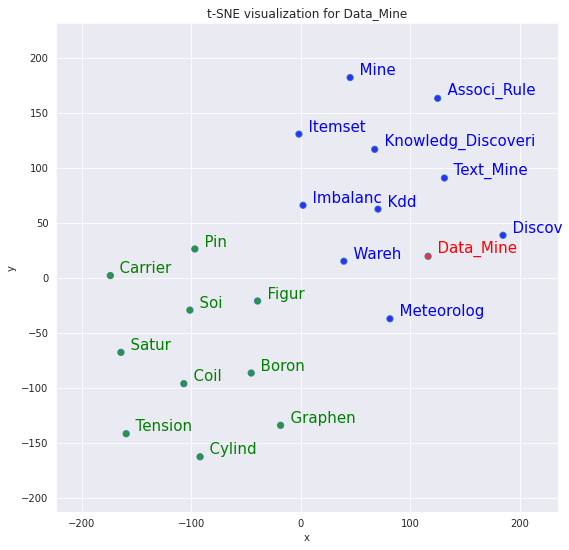

In [9]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(model, 'data_mine', [i[0] for i in model.wv.most_similar(negative=["data_mine"])])

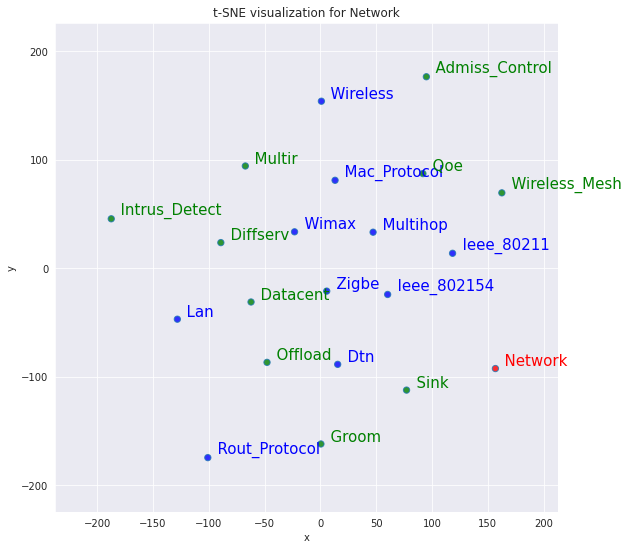

In [10]:
#10 Most similar words vs. 11th to 20th Most similar words:
tsnescatterplot(model, "network", [t[0] for t in model.wv.most_similar(positive=["network"], topn=20)][10:])

In [11]:
path = '{}/models/'.format(DATA_PATH)
Path(path).mkdir(exist_ok=True)

model_file = '{}/word2vec.model'.format(path)
model.wv.save_word2vec_format(model_file, binary=True)

INFO - 14:24:26: storing 4793x300 projection weights into ./data/models//word2vec.model
